In [1]:
import glob
import os
import shutil
from PIL import Image 
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import nibabel as nib

from modules.scandata import MriScan, MriSlice, TumourSegmentation, ScanType, ScanPlane

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
#import tensorflow_datasets as tfds
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from IPython.display import clear_output
RSEED=123

2022-12-08 14:52:52.456481: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 14:52:52.611641: I tensorflow/core/tpu/tpu_initializer_helper.cc:262] Libtpu path is: libtpu.so


In [5]:
batch_size = 128
buffer_size = 1000
img_height = 240
img_width = 240
scan_channels = 4
output_classes = 5


In [6]:
colour_list = ['w', '#d73027', '#91bfdb', '0.8', '#fee090']
cmap = ListedColormap(colour_list)

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]),cmap=cmap)
        plt.axis('off')
    plt.show()
  
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [9]:
test_image = os.path.join('data','UPENN-GBM','slice_segmentation_stratify_healthy_dropbg','test','image_data','UPENN-GBM-00593_11_allseq_079.png')
test_map = os.path.join('data','UPENN-GBM','slice_segmentation_stratify_healthy_dropbg','test','map_data','UPENN-GBM-00593_11_map_079.png' )


In [10]:
test_image = Image.open(test_image)
test_map = Image.open(test_map)

In [19]:
test_image = np.array(test_image)

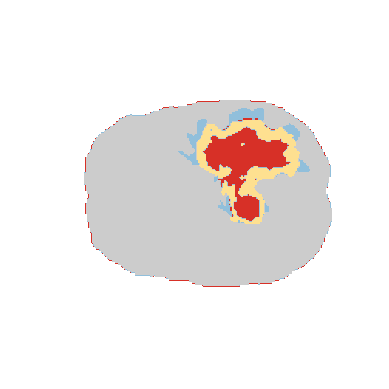

In [14]:
plt.imshow(test_map, cmap=cmap)
plt.axis('off')
plt.savefig('images/map_00593_79.png', format='png', bbox_inches='tight')

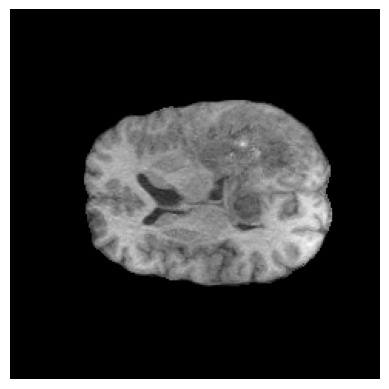

In [24]:
plt.imshow(test_image[:,:,0], cmap='gist_gray')
plt.axis('off')
plt.savefig('images/image_T1_00593_79.png', format='png', bbox_inches='tight')

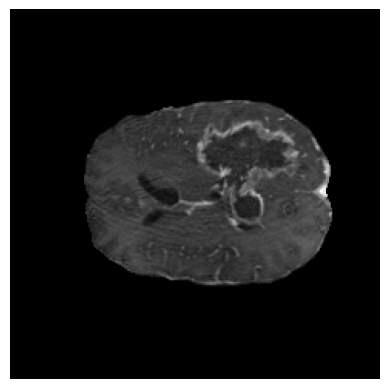

In [25]:
plt.imshow(test_image[:,:,1], cmap='gist_gray')
plt.axis('off')
plt.savefig('images/image_T1CE_00593_79.png', format='png', bbox_inches='tight')

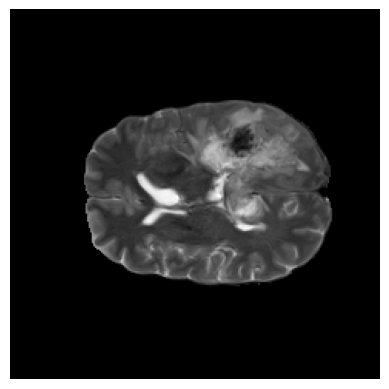

In [26]:
plt.imshow(test_image[:,:,2], cmap='gist_gray')
plt.axis('off')
plt.savefig('images/image_T2_00593_79.png', format='png', bbox_inches='tight')

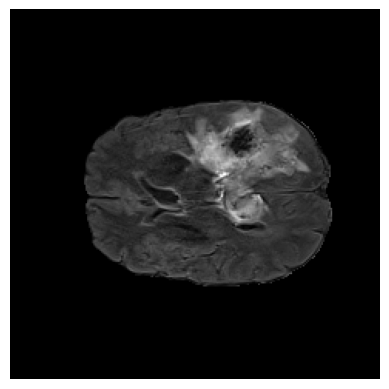

In [27]:
plt.imshow(test_image[:,:,3], cmap='gist_gray')
plt.axis('off')
plt.savefig('images/image_FLAIR_00593_79.png', format='png', bbox_inches='tight')

In [ ]:
def scaler_0_1(x):
    return x/255.0

def scaler_neg1_1(x):
    return x/127.5 - 1

def alter_segmap(x):
    return tf.where(x==4,tf.constant(3,dtype='uint8'),x)

def read_image_map(image, seg_map):
   image = tf.io.read_file(image)
   image = tf.io.decode_png(image, channels=4)
   seg_map = tf.io.read_file(seg_map)
   seg_map = tf.io.decode_png(seg_map, channels=1)
   # Change scaler below to scaler_0_1 to get initial values between 0 and 1
   return scaler_neg1_1(tf.cast(image, 'float32')) ,seg_map


In [ ]:
# Define convolution layer steps
initializer = tf.random_normal_initializer(0., 0.02)

def horizontal_convolution(input, num_filters, dropout_rate=0.0):
    
    x = tf.keras.layers.Conv2D(
        filters=num_filters,
        kernel_size=3,
        padding= 'same',
        strides=1,
        kernel_initializer=initializer,
        use_bias=False,
    )(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
    x = tf.keras.layers.Activation('relu')(x) 
    return x


def down_step(input, num_filters, dropout_rate=0.0):
    x = horizontal_convolution(
        input=input,
        num_filters=num_filters,
        dropout_rate=dropout_rate,
    )
    horizontal_out = horizontal_convolution(
        x, 
        num_filters=num_filters,
        dropout_rate=dropout_rate,
    )
    down_out = tf.keras.layers.MaxPooling2D(
        pool_size=2,
        strides=2, 
        padding = 'same'
    )(horizontal_out)
    return down_out, horizontal_out


def up_step(
    up_input, 
    horizontal_input, 
    num_filters, 
    dropout_rate=0.0, 
):
    x = tf.keras.layers.Conv2DTranspose(
        filters=num_filters,
        kernel_size=3, 
        strides=2,
        padding='same',
        kernel_initializer=initializer,
        use_bias=False,
    )(up_input)
    x = tf.keras.layers.Concatenate()([x, horizontal_input])
    x = horizontal_convolution(
        x, 
        num_filters=num_filters, 
        dropout_rate=dropout_rate
    )
    x = horizontal_convolution(
        x, 
        num_filters=num_filters, 
        dropout_rate=dropout_rate
    )
    return x

In [ ]:
# Define U-Net topology
def unet(
    input_shape, 
    output_channels, 
    scale_filters=1.0, 
    dropout_rate=0.0,
    final_dropout=True
    ):

    final_dropout_rate=0.0
    if final_dropout:
        final_dropout_rate = dropout_rate

    inputs = tf.keras.layers.Input(shape=input_shape)

    down_1, cross_1 = down_step(
        inputs, 
        int(64*scale_filters), 
        dropout_rate=dropout_rate
    )  # 240 -> 120
    down_2, cross_2 = down_step(
        down_1, 
        int(128*scale_filters), 
        dropout_rate=dropout_rate
    )  # 120 -> 60
    down_3, cross_3 = down_step(
        down_2, 
        int(256*scale_filters), 
        dropout_rate=dropout_rate
    )  # 60 -> 30
    down_4, cross_4 = down_step(
        down_3, 
        int(512*scale_filters), 
        dropout_rate=dropout_rate
    )  # 30 -> 15

    bottom = horizontal_convolution(
        down_4, 
        int(1024*scale_filters), 
        dropout_rate=dropout_rate
    )

    up_4 = up_step(
        bottom, 
        cross_4, 
        int(512*scale_filters), 
        dropout_rate=dropout_rate
    )  # 15 -> 30
    up_3 = up_step(
        up_4, 
        cross_3, 
        int(256*scale_filters), 
        dropout_rate=dropout_rate
    )  # 30 -> 60
    up_2 = up_step(
        up_3, 
        cross_2, 
        int(128*scale_filters), 
        dropout_rate=dropout_rate
    )  # 60 -> 120
    up_1 = up_step(
        up_2, 
        cross_1, 
        int(64*scale_filters), 
        dropout_rate=final_dropout_rate
    )  # 120 -> 240
    
    outputs = horizontal_convolution(up_1, output_channels)

    return tf.keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
with strategy.scope():
    input_shape = (img_width,img_height,scan_channels)
    model = unet(
        input_shape=input_shape, 
        output_channels=output_classes, 
        dropout_rate=0.2
    )
    model.load_weights(
        'model_checkpoints/unet_bs128_pat10_dr0.2_lr0.0001_scratch-2022-12-03-22:56:03-085-0.0323.ckpt'
        )
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

In [ ]:
# create test data
test_image_dir = os.path.join('data','UPENN-GBM','slice_segmentation_stratify_healthy','test','image_data')
test_map_dir = os.path.join('data','UPENN-GBM','slice_segmentation_stratify_healthy','test','map_data')


In [ ]:

test_image_filenames = os.listdir(test_image_dir)
test_image_filepaths = [os.path.join(test_image_dir,x) for x in test_image_filenames]
test_map_filepaths = [
    os.path.join(test_map_dir,x.replace('allseq','map')) for x in test_image_filenames
]


In [ ]:
test_image_data = tf.data.Dataset.list_files(test_image_filepaths, shuffle=False)
test_map_data = tf.data.Dataset.list_files(test_map_filepaths, shuffle=False)
test_data = tf.data.Dataset.zip((test_image_data, test_map_data))
test_batch = (
    test_data
    .shuffle(buffer_size, seed=tf.constant(RSEED,dtype='int64'))
    .map(read_image_map)
    .batch(32),
)

In [ ]:
images, masks = next(iter(test_batch[0].take(1)))

    

In [ ]:
num=30
sample_image, sample_mask = images[num], masks[num]
show_predictions()

In [ ]:
test_patients = list(set([filename[:15] for filename in test_image_filenames]))


for patient in test_patients:
    for pred_slice in range(155):
        scan_image_name = f'{patient}_11_allseq_{pred_slice:03}.png'
        scan_image = tf.io.read_file(os.path.join(test_image_dir,scan_image_name))
        scan_image = tf.io.decode_png(scan_image, channels=4)
        scan_map = np.array(Image.open(
            os.path.join(test_map_dir,scan_image_name.replace('allseq','map'))
        ))
        tensor_image = tf.expand_dims(
            scaler_neg1_1(tf.cast(scan_image, 'float32')),
            0
        )
        
        pred_map = np.squeeze(np.argmax(model.predict(tensor_image), axis=-1))
        pred_map[-1,-4:] = 1,2,3,4
        scan_map[-1,-4:] = 1,2,3,4
        plots=[pred_map]
        cmaps=[cmap]
        fig, axes = plt.subplots(1,1,figsize=(10, 10))
        plt.subplots_adjust(wspace=0, hspace=0)
        for i in range(1):
            axes[i].imshow(plots[i], cmap=cmaps[i])
            axes[i].axis('off')
        plt_name = os.path.join('prediction_only',scan_image_name.replace('allseq','predmap'))
        fig.savefig(plt_name, format='png', bbox_inches='tight')
        plt.close()
